In [1]:
import numpy as np
from scipy.io.wavfile import write
from scipy.signal import windows

# --- Configuration ---
sample_rate = 44100      # Samples per second (CD quality)
burst_frequency = 3000   # Frequency of the burst (4 kHz is a sharp, clear tone)
duration_seconds = 0.5  # Very short duration: 50 milliseconds

# --- 1. Generate Time and Sample Count ---
num_samples = int(sample_rate * duration_seconds)
t = np.linspace(0, duration_seconds, num_samples, endpoint=False)

# --- 2. Generate the High-Frequency Sine Wave ---
# Create the continuous sine wave for the duration
sine_wave = np.sin(2 * np.pi * burst_frequency * t)

# --- 3. Apply a Window (Fade In/Out) ---
# A Blackman window smoothly fades the signal in and out,
# preventing an abrupt "click" at the start and end of the burst,
# which can add unwanted noise to the measurement.
window = windows.blackman(num_samples)
windowed_signal = sine_wave * window

# --- 4. Normalize and Convert to 16-bit Integer Format ---
# Scale the floating-point signal to the 16-bit integer range.
max_int16 = 32767
audio_data = (windowed_signal * max_int16).astype(np.int16)

# --- 5. Save as WAV File ---
output_filename = f"audio_chirp_{burst_frequency}Hz_{int(duration_seconds*1000)}ms.wav"
write(output_filename, sample_rate, audio_data)

print(f"Successfully generated chirp sound: **{output_filename}**")

Successfully generated chirp sound: **audio_chirp_3000Hz_500ms.wav**


In [2]:
import numpy as np
from scipy.io.wavfile import write

# Configuration for silent noise
sample_rate = 44100  # Match the sample rate used elsewhere
duration_seconds = 10.0  # Match soundscape duration
num_samples = int(sample_rate * duration_seconds)

# Generate very silent white noise (low amplitude) for 4 channels
noise_amplitude = 0.0001  # Very low amplitude for silence
silent_noise = np.random.normal(0, noise_amplitude, (num_samples, 4)).astype(np.float32)

# Normalize to 16-bit integer range
max_int16 = 32767
audio_data = (silent_noise * max_int16).astype(np.int16)

# Save as WAV file
output_filename = "background_noise.wav"
write(output_filename, sample_rate, audio_data)

print(f"Successfully generated silent noise: {output_filename}")
print("chanells shape:", audio_data.shape)

Successfully generated silent noise: background_noise.wav
chanells shape: (441000, 4)


In [ ]:
import ambiscaper
import numpy as np
import os

# --- AmbiScaper settings ---
# Set the desired soundscape duration 10s
soundscape_duration = 10.0 
ambisonics_order = 1
# Assuming 'audio_chirp_3000Hz_500ms.wav' is in the same directory as the script
foreground_folder = os.path.abspath('.') 
number_of_chirps = 5 # Within the required range of 30 to 100

### Create an ambiscaper instance
ambi = ambiscaper.AmbiScaper(duration=soundscape_duration,
                             ambisonics_order=ambisonics_order,
                             fg_path=foreground_folder,
                             bg_path=foreground_folder)


# this will only show up on channel 1 (which is unwanted tbh but whatever)
ambi.add_background(source_file=('const', 'background_noise.wav'),
                   source_time=('const', 0.))
                             
# --- Add multiple events using a loop ---
# Chirp duration is 0.5 seconds (500ms)
chirp_duration = 0.5 

for i in range(number_of_chirps):
    ### Add an event (a single chirp)
    # The event_time parameter samples a random start time for each chirp 
    # between 0 and (soundscape_duration - chirp_duration)
    # This ensures the entire chirp fits within the 10-minute soundscape.
    ambi.add_event(source_file=('const', 'audio_chirp_3000Hz_500ms.wav'),
                   source_time=('const', 0),
                   event_time=('uniform', 0, soundscape_duration - chirp_duration),
                   event_duration=('const', chirp_duration),
                   event_azimuth=('uniform', 0, 2 * np.pi), # Random horizontal angle (0 to 360 degrees)
                   event_elevation=('uniform', -np.pi/2, np.pi/2), # Random vertical angle (-90 to +90 degrees)
                   event_spread=('const', 0), # Point source
                   snr=('const', 0),
                   pitch_shift=('const', 1),
                   time_stretch=('const', 1))

# --- Generate the audio and the annotation ---
outfolder = './ambi-audios-10min'

os.makedirs(outfolder, exist_ok=True)

destination_path = os.path.join(outfolder, "test_10min_50_chirps")

print(f"Generating soundscape of {soundscape_duration}s with {number_of_chirps} chirps...")
ambi.generate(destination_path=destination_path,
              generate_txt=True,
              disable_instantiation_warnings=True)
print(f"Generation complete. Output files saved to: {outfolder}")

audiopath = "ambi-audios-10min/test_10min_50_chirps/test_10min_50_chirps.wav"

/workspaces/Masters-Thesis/ambiscaper/ambiscaper/core.py:2785: AmbiScaperWarning: Destination path exists: ./ambi-audios-10min/test_10min_50_chirps
  warnings.warn('Destination path exists: ' + destination_path, AmbiScaperWarning)
output_file: /tmp/tmpc6dxs002.wav already exists and will be overwritten on build


Generating soundscape of 10.0s with 5 chirps...


output_file: ./ambi-audios-10min/test_10min_50_chirps/source/bg0.wav already exists and will be overwritten on build
output_file: /tmp/tmp_rxq7yk4.wav already exists and will be overwritten on build
Input formats were only specified for 0 out of 4 files.The last 4 files will remain unformatted.
output_file: /tmp/tmpcv2n1tjm.wav already exists and will be overwritten on build
For this stretch factor, the stretch effect has better performance.
output_file: ./ambi-audios-10min/test_10min_50_chirps/source/fg2.wav already exists and will be overwritten on build
output_file: /tmp/tmp9vdjp7w4.wav already exists and will be overwritten on build
Input formats were only specified for 0 out of 4 files.The last 4 files will remain unformatted.
output_file: /tmp/tmps9rjmr__.wav already exists and will be overwritten on build
For this stretch factor, the stretch effect has better performance.
output_file: ./ambi-audios-10min/test_10min_50_chirps/source/fg4.wav already exists and will be overwritten 

Generation complete. Output files saved to: ./ambi-audios-10min


### VIz

In [4]:
import scipy.io.wavfile as wav
import numpy as np

sample_rate, data = wav.read(audiopath)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Data shape (frames, channels): {data.shape}")
print(f"Data type: {data.dtype}")
print(f"Duration: {data.shape[0] / sample_rate:.2f} seconds")
print(f"Number of Channels: {data.shape[1] if len(data.shape) > 1 else 1}")

Sample Rate: 48000 Hz
Data shape (frames, channels): (480000, 4)
Data type: int16
Duration: 10.00 seconds
Number of Channels: 4


In [5]:
times = np.linspace(0, data.shape[0] / sample_rate, num=data.shape[0])
times.shape

(480000,)

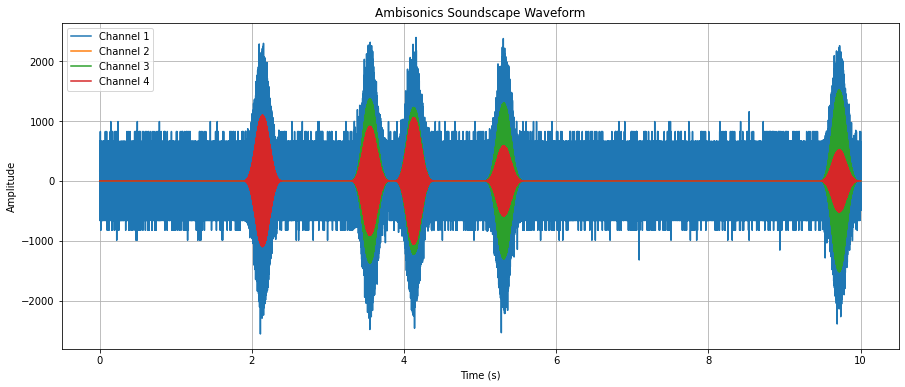

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(times, data[:, 0], label='Channel 1')
plt.plot(times, data[:, 1], label='Channel 2')
plt.plot(times, data[:, 2], label='Channel 3')
plt.plot(times, data[:, 3], label='Channel 4')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Ambisonics Soundscape Waveform')
plt.legend()
plt.grid()
plt.show()

/home/vscode/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


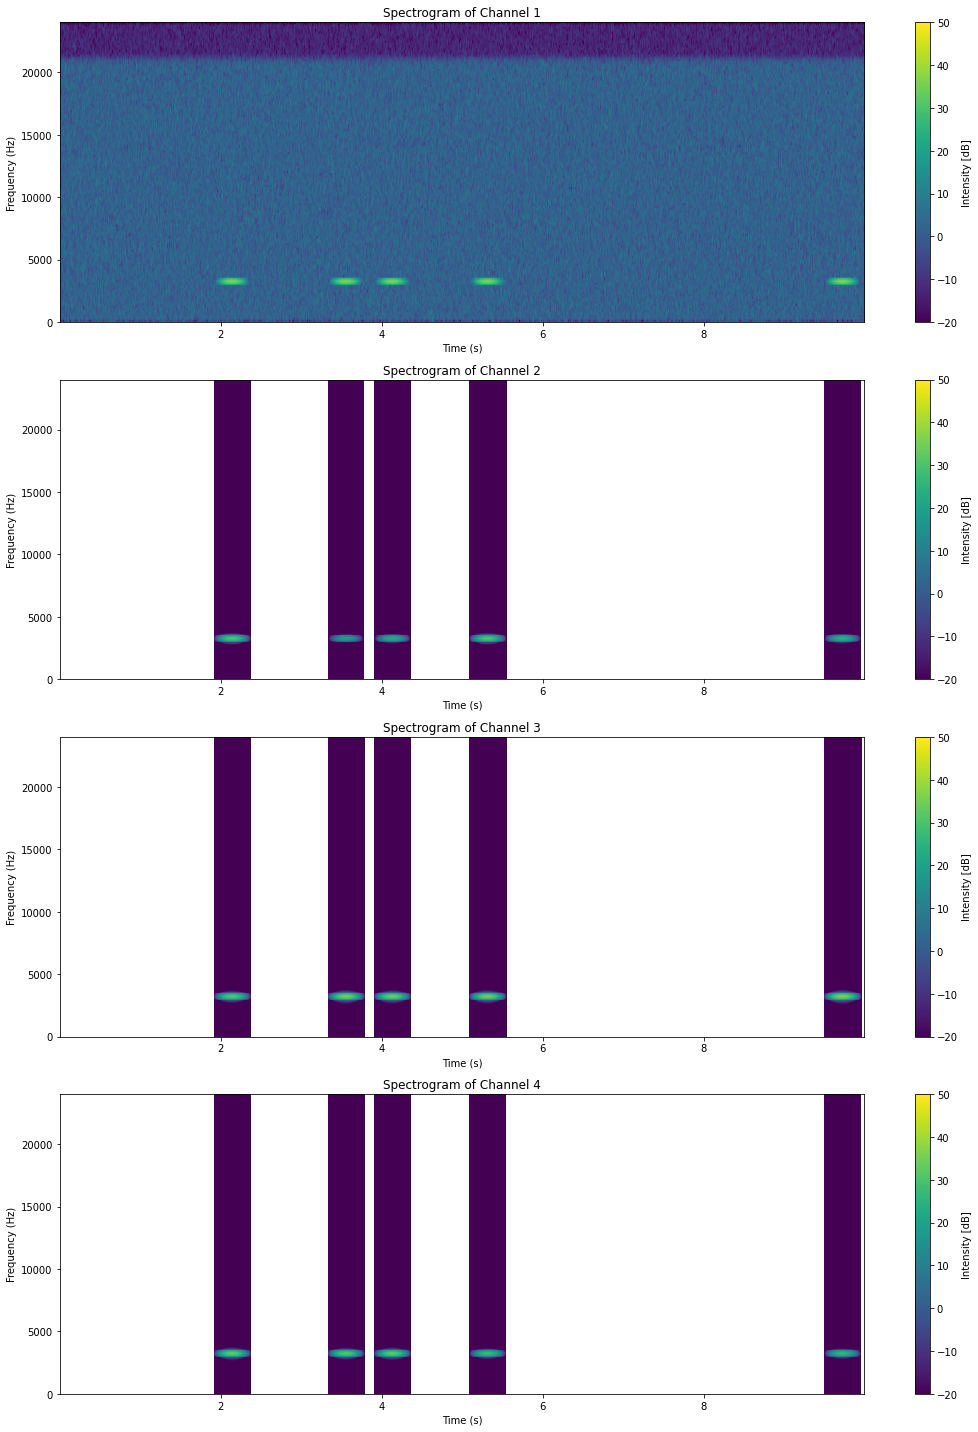

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(15, 20))

for i in range(4):
    spectrum, freqs, t, im = axs[i].specgram(data[:, i], Fs=sample_rate, vmin=-20, vmax=50)
    axs[i].set_title(f'Spectrogram of Channel {i+1}')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=axs[i], label='Intensity [dB]')

plt.tight_layout()
plt.show()

## SFT

In [8]:
from scipy.signal import stft

# Perform Short-Time Fourier Transform on each channel
Zxx_channels = []
for ch in range(data.shape[1]):
    f, t_stft, Zxx = stft(data[:, ch], fs=sample_rate, nperseg=1024)
    Zxx_channels.append(Zxx)

# Zxx_channels is a list of STFT results for each channel
print(f"STFT shapes: {[Z.shape for Z in Zxx_channels]}")
print(f"Frequency bins: {f.shape}")
print(f"Time segments: {t_stft.shape}")

STFT shapes: [(513, 939), (513, 939), (513, 939), (513, 939)]
Frequency bins: (513,)
Time segments: (939,)


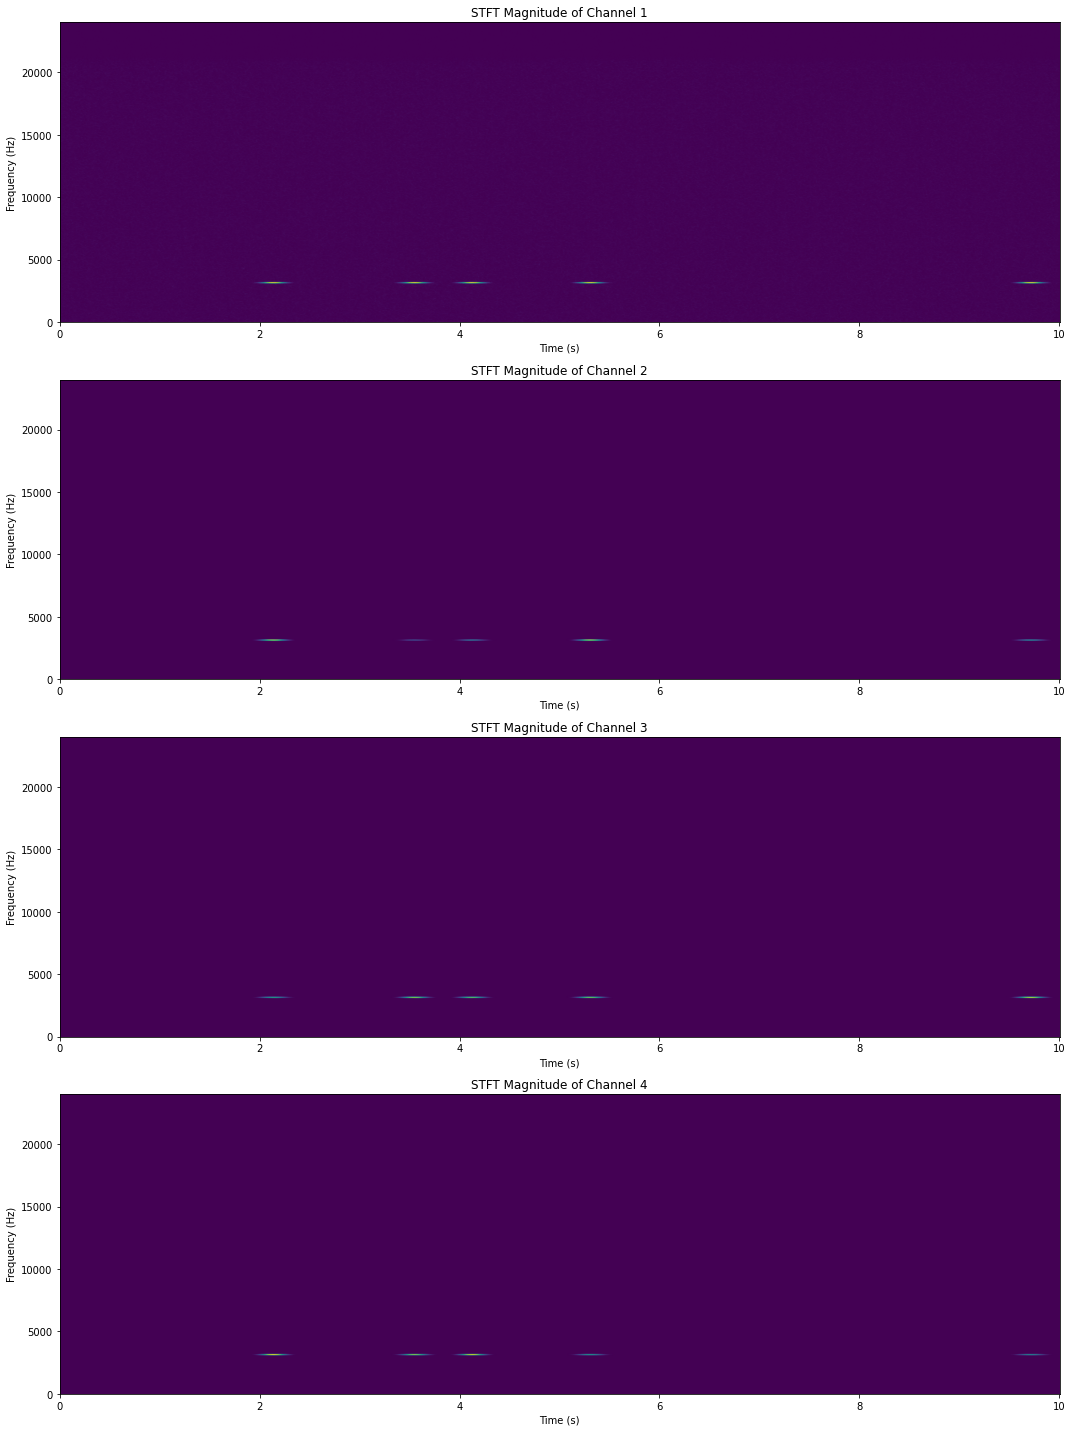

In [9]:
import matplotlib.pyplot as plt

# Plot the STFT magnitude for each channel
fig, axs = plt.subplots(4, 1, figsize=(15, 20))

for i in range(4):
    axs[i].pcolormesh(t_stft, f, np.abs(Zxx_channels[i]), shading='gouraud')
    axs[i].set_title(f'STFT Magnitude of Channel {i+1}')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [10]:
import jams

# Load the JAMS file
jams_file_path = './ambi-audios-10min/test_10min_50_chirps/test_10min_50_chirps.jams'
jam = jams.load(jams_file_path)

# Extract chirp data
chirps = []
for annotation in jam.annotations:
    if annotation.namespace == 'ambiscaper_sound_event':
        for event in annotation.data:
            if event.value['role'] == 'foreground':
                chirps.append({
                    'timestamp': event.time,
                    'azimuth': event.value['event_azimuth'],
                    'elevation': event.value['event_elevation']
                })

# Display the extracted data
print(chirps)

[{'timestamp': 1.8985535900462578, 'azimuth': 3.794818306226821, 'elevation': -0.5878723794071974}, {'timestamp': 3.309532361221768, 'azimuth': 6.046171521994306, 'elevation': 0.9715705095106024}, {'timestamp': 3.8870781826839034, 'azimuth': 5.948594051376184, 'elevation': 0.8304640188583425}, {'timestamp': 5.068829571650886, 'azimuth': 5.314221168844995, 'elevation': 0.9005877281536585}, {'timestamp': 9.477040914246187, 'azimuth': 3.843021714640752, 'elevation': 1.1511898565074334}]


In [11]:
# convert Zxx_channels to numpy
Zxx_channels = np.array(Zxx_channels)
print("Zxx_channels shape:", Zxx_channels.shape)

# convert from (4, 513, 939) to (939, 513, 4)
Zxx_channels = np.transpose(Zxx_channels, (2, 1, 0))
print("Zxx_channels transposed shape:", Zxx_channels.shape)

# give each bin a timestamp from and to based on t_stft
time_bins = []
for i in range(len(t_stft)-1):
    time_bins.append((t_stft[i], t_stft[i+1]))

print("Time bins:", len(time_bins))
time_bins

Zxx_channels shape: (4, 513, 939)
Zxx_channels transposed shape: (939, 513, 4)
Time bins: 938


[(0.0, 0.010666666666666666),
 (0.010666666666666666, 0.021333333333333336),
 (0.021333333333333336, 0.032),
 (0.032, 0.04266666666666667),
 (0.04266666666666667, 0.05333333333333334),
 (0.05333333333333334, 0.064),
 (0.064, 0.07466666666666666),
 (0.07466666666666666, 0.08533333333333333),
 (0.08533333333333333, 0.096),
 (0.096, 0.10666666666666666),
 (0.10666666666666666, 0.11733333333333333),
 (0.11733333333333333, 0.128),
 (0.128, 0.1386666666666667),
 (0.1386666666666667, 0.14933333333333335),
 (0.14933333333333335, 0.16),
 (0.16, 0.1706666666666667),
 (0.1706666666666667, 0.18133333333333335),
 (0.18133333333333335, 0.192),
 (0.192, 0.2026666666666667),
 (0.2026666666666667, 0.21333333333333335),
 (0.21333333333333335, 0.224),
 (0.224, 0.23466666666666666),
 (0.23466666666666666, 0.24533333333333335),
 (0.24533333333333335, 0.256),
 (0.256, 0.26666666666666666),
 (0.26666666666666666, 0.2773333333333333),
 (0.2773333333333333, 0.28800000000000003),
 (0.28800000000000003, 0.298666